In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
import joblib
from pathlib import Path


In [3]:
# 1.  Locate & load the two files
data_dir = Path(r"D:\University\Aalto\Project_course\CleanedData\features")
filenames = ["all_patient_features.csv", "all_patient_features_db2.csv"]
dfs = [pd.read_csv(data_dir / f) for f in filenames]

#Which columns are "metadata"?
meta_cols = ["patient_id", "Age", "Height", "Weight", "Gender", "fs"]


def split_meta_beatwise(df, meta_cols):
    """Return (meta_df, beatwise_df) and PRESERVE patient_id in beatwise_df."""
    meta_df = df.loc[:, [c for c in meta_cols if c in df.columns]]

    beatwise_cols = [
        c for c in df.columns
        if (
            c not in meta_cols                      # not metadata
        )
    ]

    # Ensure patient_id is present for merging later
    beatwise_df = df.loc[:, ["patient_id"] + beatwise_cols]

    return meta_df, beatwise_df

#Apply split to every file and concatenate
meta_parts, beat_parts = zip(
    *(split_meta_beatwise(df, meta_cols) for df in dfs)
)

meta_df      = pd.concat(meta_parts,  ignore_index=True)
beatwise_df  = pd.concat(beat_parts, ignore_index=True)


In [4]:
# Merge metadata and beatwise features on patient_id
df = meta_df.merge(beatwise_df, on="patient_id", how="inner")

# Define prefixes of the BCG-related features to keep
bcg_prefixes   = ("RI_", "RJ_", "RK_", "IJ_", "AI_", "AJ_", "AK_")
# Metadata to retain alongside BCG
meta_features  = ["Height", "Weight", "Gender", "fs"]  # keep these
#Target variable
target         = "Age"

# Any columns that should never enter the "pure‑BCG" model
non_bcg_prefixes = (
    "RR_", "HR_", "RR_SDNN", "RR_RMSSD", "RR_SDSD", "RR_CV",
    "patton", "PTT_", "fs"
)

# Filtering logic: select only useful BCG features and metadata
def keep(col: str) -> bool:
    # drop target and ID
    if col in (target, "patient_id"):
        return False
    if col.endswith(("_count", "_iqr")):
        return False
    if any(col.startswith(p) for p in non_bcg_prefixes):
        return False
    #Keep meta features you want 
    if col in meta_features:
        return True
    #keep the real BCG waveform stats 
    if col.startswith(bcg_prefixes):
        return True
    return False

# Select filtered features for input (X) and target (y)
feature_cols = [c for c in df.columns if keep(c)]
X = df[feature_cols].copy()
y = df[target].copy()

# Drop rows with insufficient valid BCG measurements (less than 5 non-NaNs)
# Even though this isnt needed because we have a cleaned data set
# I kept it just incase we receive a larger data set in the future that might have a high
# number or NaNs 
bcg_feature_columns = [c for c in X.columns if c.startswith(bcg_prefixes)]
min_bcg_non_nan = 5
mask = X[bcg_feature_columns].notna().sum(axis=1) >= min_bcg_non_nan
X = X.loc[mask].reset_index(drop=True)
y = y.loc[mask].reset_index(drop=True)


In [ ]:
# Set up preprocessing pipeline: impute missing values and scale numeric features
numeric_cols = [c for c in X.columns if c != "Gender"]
categorical_cols = ["Gender"] if "Gender" in X.columns else []

preprocess = ColumnTransformer(
    [
        ("num", Pipeline([
            ("imputer", SimpleImputer(strategy="mean")),
            ("scaler",  StandardScaler())
        ]), numeric_cols),
        ("cat", OneHotEncoder(drop="if_binary"), categorical_cols)
    ],
    remainder="drop",
)


# Define base XGBoost model and wrap it in a pipeline
xgb_inner = XGBRegressor(
    objective="reg:squarederror",
    booster="gbtree",
    random_state=42
)

pipe_inner = Pipeline([("prep", preprocess), ("reg", xgb_inner)])

# Define hyperparameter grid to explore used GPT to assist with choosing these params
param_grid = {
    "reg__learning_rate":    [0.03, 0.05, 0.07, 0.10],
    "reg__n_estimators":     [400, 800, 1200],
    "reg__max_depth":        [3, 4, 5],
    "reg__min_child_weight": [1, 3, 5],
    "reg__gamma":            [0, 0.05, 0.1],
    "reg__subsample":        [0.8, 0.9],
    "reg__colsample_bytree": [0.8, 0.9],
}

# Set up nested cross-validation: inner loop for hyperparameter tuning, outer for evaluation
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    pipe_inner,
    param_grid,
    cv=inner_cv,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    refit=True,
)

# Perform nested cross-validation and store results
cv_results = cross_validate(
    grid,
    X, y,
    cv=outer_cv,
    scoring={"MAE": make_scorer(mean_absolute_error)},
    return_estimator=True,
    n_jobs=-1,
)

print(f"Outer‑CV MAE: {-cv_results['test_MAE'].mean():.2f} "
      f"± {cv_results['test_MAE'].std():.2f}")



# Retrieve the best hyperparameter set from the best-performing outer fold
best_idx    = np.argmin(cv_results["test_MAE"])
best_params = cv_results["estimator"][best_idx].best_params_
print("Best hyper‑params:", best_params)


# Split data into training and validation sets for final model fitting with early stopping
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.10,
    random_state=1,
    stratify=pd.qcut(y, 5, duplicates="drop")
)


# Fit preprocessing only on the training data
preprocess_final = preprocess.fit(X_train)
X_train_proc = preprocess_final.transform(X_train)
X_val_proc   = preprocess_final.transform(X_val)

# Rebuild final XGBoost model using selected hyperparameters and early stopping
best_xgb_params = {k.replace("reg__", ""): v for k, v in best_params.items()}
reg_final = XGBRegressor(
    **best_xgb_params,
    objective="reg:squarederror",
    booster="gbtree",
    random_state=42,
    early_stopping_rounds=20,
    eval_metric="mae"
)

reg_final.fit(
    X_train_proc, y_train,
    eval_set=[(X_val_proc, y_val)],
    verbose=False
)

# Wrap preprocess + regressor into one pipeline for convenience
from sklearn.pipeline import make_pipeline
final_model = make_pipeline(preprocess_final, reg_final)

# Save the trained model
joblib.dump(final_model, "final_bcg_age_model_es.pkl")

# Save feature importance scores
feature_names = preprocess_final.get_feature_names_out()
importances   = reg_final.feature_importances_
(pd.Series(importances, index=feature_names)
   .sort_values(ascending=False)
   .to_csv("final_bcg_feature_importance.csv"))

print("✓  final model saved as  final_bcg_age_model_es.pkl")
print("✓  feature importances  → final_bcg_feature_importance.csv")

Outer‑CV MAE: -9.59 ± 0.88
Best hyper‑params: {'reg__colsample_bytree': 0.8, 'reg__gamma': 0, 'reg__learning_rate': 0.03, 'reg__max_depth': 3, 'reg__min_child_weight': 1, 'reg__n_estimators': 400, 'reg__subsample': 0.8}
✓  final model saved as  final_bcg_age_model_es.pkl
✓  feature importances  → final_bcg_feature_importance.csv


Top features by XGBoost gain:

num__AK_median     825.549
num__RK_min        657.429
num__RK_median     610.937
num__AK_kurtosis   528.954
num__AJ_min        527.949
num__IJ_median     462.560
num__RK_max        460.435
num__RI_kurtosis   450.694
num__AJ_mean       330.849
num__RK_mean       327.925
num__AJ_median     318.731
num__RJ_std        299.848
num__RJ_median     284.101
num__AJ_kurtosis   274.747
num__AI_mean       261.925
num__AJ_max        255.424
num__IJ_max        249.119
num__RI_min        216.805
num__IJ_range      213.606
num__AI_median     204.921


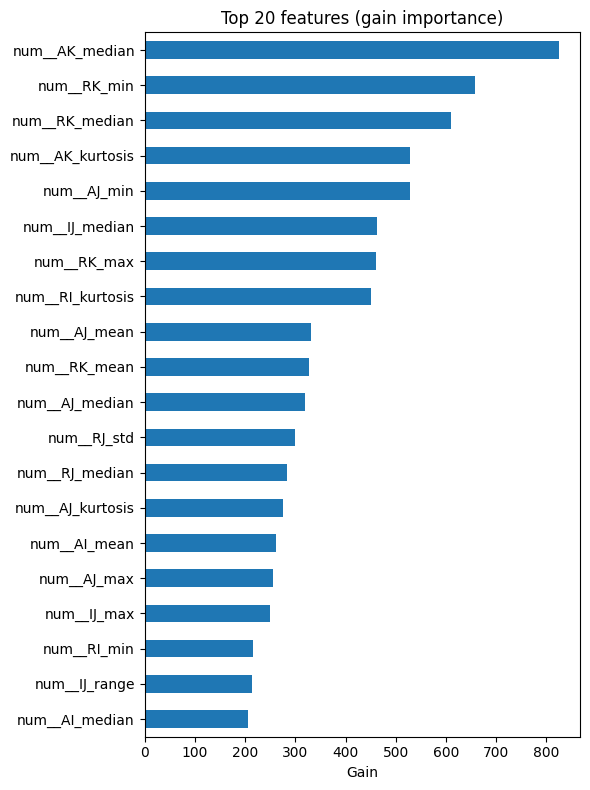

In [ ]:
# Load trained model pipeline
import joblib
import pandas as pd
import matplotlib.pyplot as plt

PIPE_PATH = "final_bcg_age_model_es.pkl"   # adjust if you renamed it
TOP_K     = 20                             # how many features to display

pipeline = joblib.load(PIPE_PATH)

# Extract preprocessing and trained model
prep   = pipeline.named_steps["columntransformer"]
model  = pipeline.named_steps["xgbregressor"]   # XGBRegressor object

# Get transformed feature names (after encoding, scaling, etc.)
feature_names = prep.get_feature_names_out()

# Retrieve XGBoost’s gain-based feature importances
importances = model.get_booster().get_score(importance_type="gain")
idx_to_name = {f"f{i}": name for i, name in enumerate(feature_names)}
gain_series = pd.Series(
    {idx_to_name[k]: v for k, v in importances.items()},
    name="importance"
).sort_values(ascending=False)

# Display and plot the top-k most important features
top = gain_series.head(TOP_K)
print("Top features by XGBoost gain:\n")
print(top.to_string(float_format="%.3f"))

# Horizontal bar plot for quick visual
top.iloc[::-1].plot.barh(figsize=(6, 8))
plt.title(f"Top {TOP_K} features (gain importance)")
plt.xlabel("Gain")
plt.tight_layout()
plt.show()


### Graphs


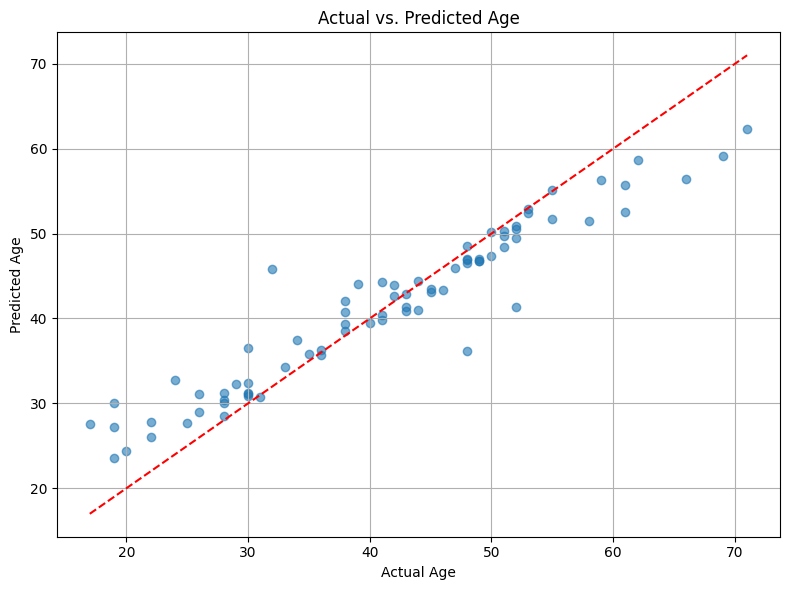

c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


(3.2818067971762126, 4.607750533514801, 0.867929072675166)

In [5]:
import joblib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Load the trained model pipeline
pipeline = joblib.load("final_bcg_age_model_es.pkl")

# Extract preprocessing and model components
preprocess = pipeline.named_steps["columntransformer"]
model = pipeline.named_steps["xgbregressor"]

# Assume X and y are available from the session (as per user context)
# Reprocess full X data to get predictions
X_proc = preprocess.transform(X)
y_pred = model.predict(X_proc)

# Create a dataframe for plotting
results_df = pd.DataFrame({
    "Actual Age": y,
    "Predicted Age": y_pred
})

# Plot actual vs. predicted age
plt.figure(figsize=(8, 6))
plt.scatter(results_df["Actual Age"], results_df["Predicted Age"], alpha=0.6)
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel("Actual Age")
plt.ylabel("Predicted Age")
plt.title("Actual vs. Predicted Age")
plt.grid(True)
plt.tight_layout()
plt.show()

# Additional performance metrics for reporting
mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

(mae, rmse, r2)


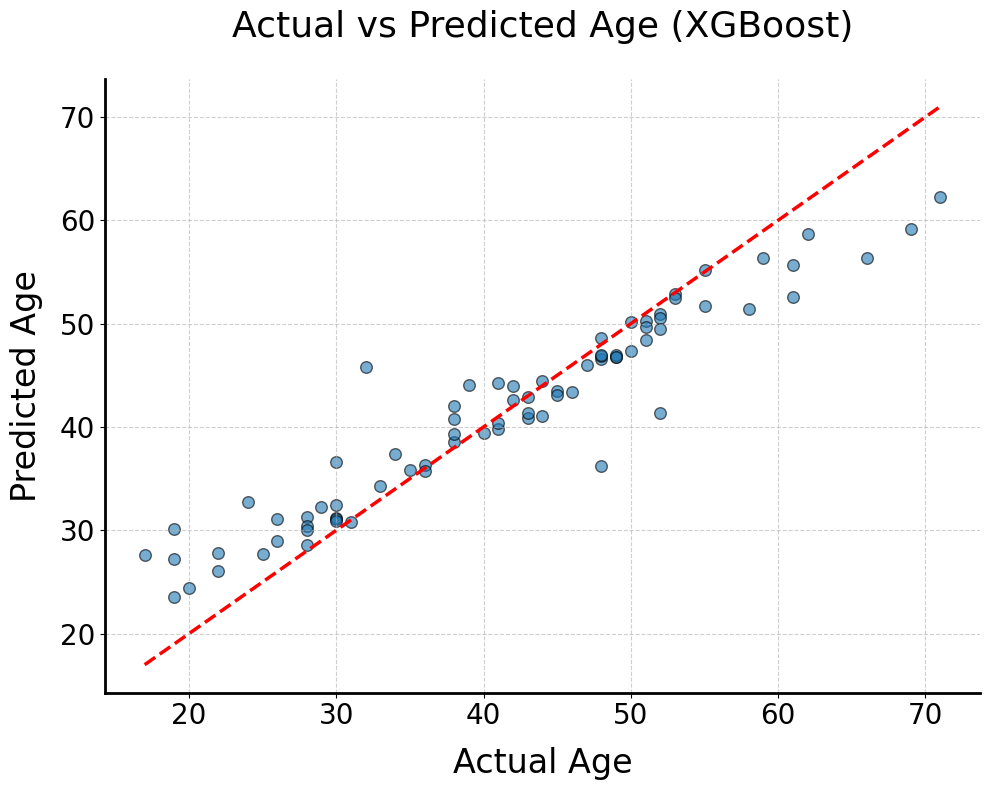

MAE  : 3.28
RMSE : 4.61
R²   : 0.87


c:\Users\Dell\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [ ]:
# Plotting
plt.figure(figsize=(10, 8))
plt.scatter(y, y_pred, alpha=0.6, edgecolor='k', s=70)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2.5)

plt.xlabel("Actual Age", fontsize=24, labelpad=12)
plt.ylabel("Predicted Age", fontsize=24, labelpad=12)
plt.title("Actual vs Predicted Age (XGBoost)", fontsize=26, pad=30)

# Style ticks and borders
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid(True, linestyle='--', alpha=0.6)

# Thicken axis lines
ax = plt.gca()
ax.spines['bottom'].set_linewidth(2)
ax.spines['left'].set_linewidth(2)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.savefig("xgboost_actual_vs_predicted.pdf", format="pdf")   # or .svg
plt.show()

# Optional metrics printout
mae = mean_absolute_error(y, y_pred)
rmse = mean_squared_error(y, y_pred, squared=False)
r2 = r2_score(y, y_pred)

print(f"MAE  : {mae:.2f}")
print(f"RMSE : {rmse:.2f}")
print(f"R²   : {r2:.2f}")